In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
import pickle
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import pairwise_distances
import pandas as pd
import seaborn as sns

In [2]:
input_data = pickle.load(open('../../model/output/german0316_margin_0.5_alpha_0.95_multiply.pkl', 'rb'))
rules = input_data['paths']

In [3]:
s_conf = np.zeros(len(rules[0]['sample']))
for r in rules:
    s_conf += np.array(r['sample'])# * r['value']
s_conf /= np.max(np.abs(s_conf))
r_conf = np.array([r['confidence'] for r in rules])
mat = np.array([np.array(r['sample']) for r in rules])
mat = mat.astype(np.float32)

In [4]:
def anomaly_detection(mat, row_conf = None, col_conf = None):
    if row_conf is None:
        row_conf = np.ones(mat.shape[0])
    if col_conf is None:
        col_conf = np.ones(mat.shape[1])
    s_dist = pairwise_distances(X = mat.transpose() * row_conf, metric='euclidean')
    clf = LocalOutlierFactor(metric="precomputed")
    clf.fit(s_dist)
    col_lof = -clf.negative_outlier_factor_

    r_dist = pairwise_distances(X = mat * col_conf, metric='euclidean')
    clf = LocalOutlierFactor(metric="precomputed")
    clf.fit(r_dist)
    row_lof = -clf.negative_outlier_factor_

    row_weight = row_lof / np.sum(row_lof) * len(row_lof)
    col_weight = col_lof / np.sum(col_lof) * len(col_lof)

    for i in range(3):
        print('column lof', np.mean(col_lof), np.max(col_lof))
        X = ((mat * (col_conf * col_weight)).transpose() * row_weight).transpose()
        r_dist = pairwise_distances(X = X, metric='euclidean')
        print(X[0])
        clf = LocalOutlierFactor(metric="precomputed")
        clf.fit(r_dist)
        row_lof = -clf.negative_outlier_factor_
        print('row lof', np.mean(row_lof), np.max(row_lof))

        row_weight = row_lof / np.sum(row_lof) * len(row_lof)
        X = (mat * col_weight).transpose() * (row_conf * row_weight)
        s_dist = pairwise_distances(X = X, metric='euclidean') 
        clf = LocalOutlierFactor(metric="precomputed")
        clf.fit(s_dist)
        col_lof = -clf.negative_outlier_factor_
        col_weight = col_lof / np.sum(col_lof) * len(col_lof)

    return row_lof, col_lof

In [5]:
mat2 = np.array([[1,1,1,0,0],[1,1,1,0,0],[1,1,1,0,1],[0,0,0,1,1]])

r_lof, s_lof = anomaly_detection(mat2)
print(r_lof, s_lof)

column lof 1.0002321401252527 1.0346543496784795
[0.97945276 0.97945276 0.97945276 0.         0.        ]
row lof 1.0001849583987141 1.0275723143625892
column lof 1.000215331590193 1.0333552110493542
[0.98266499 0.98266499 0.98266499 0.         0.        ]
row lof 1.0002232790398127 1.030334943338277
column lof 1.0002198243072438 1.0337071172712298
[0.98167903 0.98167903 0.98167903 0.         0.        ]
row lof 1.0002109614933745 1.0294740140045198
[0.99045661 0.99045661 1.02947401 0.99045661] [0.99187239 0.99187239 0.99187239 0.99187239 1.03360289]


n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
n_neighbors (20) is greater than the total number of samples (4). n_neighbors will be set to (n_samples - 1) for estimation.
n_neighbors (20) is greater than the total number of samples (4). n_neighbors will be set to (n_samples - 1) for estimation.
n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
n_neighbors (20) is greater than the total number of samples (4). n_neighbors will be set to (n_samples - 1) for estimation.
n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
n_neighbors (20) is greater than the total number of samples (4). n_neighbors will be set to (n_samples - 1) for estimation.
n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.


In [175]:

def anomaly_detection_3_sigma(mat, row_conf = None, col_conf = None):
    if row_conf is None:
        row_conf = np.ones(mat.shape[0])
    if col_conf is None:
        col_conf = np.ones(mat.shape[1])
    s_dist = pairwise_distances(X = mat.transpose() * row_conf, metric='jaccard')
    clf = LocalOutlierFactor(n_neighbors = 2, metric="precomputed")
    clf.fit(s_dist)
    col_lof = -clf.negative_outlier_factor_

    r_dist = pairwise_distances(X = mat * col_conf, metric='jaccard')
    clf = LocalOutlierFactor(n_neighbors = 2, metric="precomputed")
    clf.fit(r_dist)
    row_lof = -clf.negative_outlier_factor_

    row_lof_thres = row_lof.mean() + row_lof.std() * 3
    col_lof_thres = col_lof.mean() + col_lof.std() * 3

    row_weight = np.array([lof ** (np.sum(col_lof[np.flatnonzero(mat[i, :])] > col_lof_thres) / len(np.flatnonzero(mat[i, :]))) for i, lof in enumerate(row_lof)])
    col_weight = np.array([lof ** (np.sum(row_lof[np.flatnonzero(mat[:, i])] > row_lof_thres) / len(np.flatnonzero(mat[:, i]))) for i, lof in enumerate(col_lof)])
    # / np.sum(row_lof) * len(row_lof)
    # col_weight = col_lof
    # / np.sum(col_lof) * len(col_lof)

    for i in range(1):
        print('column lof', np.mean(col_lof), np.max(col_lof))
        #r_dist = pairwise_distances(X = ((mat * col_weight).transpose() * row_weight).transpose(), metric='euclidean')
        X = ((mat * (col_conf * col_weight)).transpose() * row_weight).transpose()
        r_dist = pairwise_distances(X = X, metric='euclidean')
        print(X[0])
        clf = LocalOutlierFactor(metric="precomputed")
        clf.fit(r_dist)
        row_lof = -clf.negative_outlier_factor_
        print('row lof', np.mean(row_lof), np.max(row_lof))

        #row_weight = row_lof# / np.sum(row_lof) * len(row_lof)
        row_weight = np.array([lof ** (np.sum(col_lof[np.flatnonzero(mat[i, :])] > col_lof_thres) / len(np.flatnonzero(mat[i, :]))) for i, lof in enumerate(row_lof)])
        X = (mat * col_weight).transpose() * (row_conf * row_weight)
        print(X[0])
        #s_dist = pairwise_distances(X = (mat * col_weight).transpose() * row_weight, metric='euclidean') 
        s_dist = pairwise_distances(X = X, metric='euclidean') 
        clf = LocalOutlierFactor(metric="precomputed")
        clf.fit(s_dist)
        col_lof = -clf.negative_outlier_factor_
        #col_weight = col_lof# / np.sum(col_lof) * len(col_lof)
        col_weight = np.array([lof ** (np.sum(row_lof[np.flatnonzero(mat[:, i])] > row_lof_thres) / len(np.flatnonzero(mat[:, i]))) for i, lof in enumerate(col_lof)])

    return row_lof, col_lof

In [166]:
print(r_lof)

[0.98580443 0.98580443 1.04448099 0.98580443]


In [6]:
mat = np.array([np.array(r['sample']) for r in rules])
mat = mat.astype(np.float32)

r_lof, s_lof = anomaly_detection(mat)
#r_lof, s_lof = anomaly_detection(mat, row_conf=r_conf, col_conf=s_conf)

column lof 1.0042827988036847 1.03623242081404
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.      

In [7]:
def plot_anomaly(mat, r_lof, s_lof, type = 'rule', y = 'max', anomaly_precent = 0.05):
    if type != 'rule':
        (r_lof, s_lof) = (s_lof, r_lof)
        mat = mat.transpose()
    ordered_s_lof = sorted(s_lof)[::-1][int(len(s_lof) * anomaly_precent)]
    px = []
    pmax = []
    pmean = []
    pmedian = []
    panum = []
    pnum = []
    ppercent = []
    for i in range(len(r_lof)):
        x = r_lof[i]
        idxes = np.flatnonzero(mat[i, :])
        pmedian.append(np.median(s_lof[idxes]))
        pmean.append(np.mean(s_lof[idxes]))
        pmax.append(np.max(s_lof[idxes]))
        pnum.append(len(idxes))
        panum.append(np.sum(s_lof[idxes] > ordered_s_lof))
        ppercent.append(np.sum(s_lof[idxes] > ordered_s_lof) / len(idxes))
        px.append(x)
    df = pd.DataFrame({ 'x': px, 'max': pmax, 'mean': pmean, 'median': pmedian, 'anomaly_num': panum, 'num': pnum, 'percent': ppercent })
    sns.scatterplot(data=df, x='x', y=y)

In [140]:
r_lof[[290, 348, 841, 687, 804]]

array([ 2.20946353,  3.30965944,  4.25180078, 18.56647478,  2.65001279])

In [138]:
p3 = [i for i, p in enumerate(paths) if p['level'] > 0]
print(r_lof[p3].argsort()[::-1][:5])

[622 399 522  65 161]


In [103]:
def anomaly_detection_jaccard(mat, row_conf = None, col_conf = None):
    if row_conf is None:
        row_conf = np.ones(mat.shape[0])
    if col_conf is None:
        col_conf = np.ones(mat.shape[1])
    s_dist = global_s_dist #pairwise_distances(X = mat.transpose() * row_conf, metric='jaccard')
    clf = LocalOutlierFactor(n_neighbors = 5, metric="precomputed")
    clf.fit(s_dist)
    col_lof = -clf.negative_outlier_factor_

    r_dist = global_r_dist #pairwise_distances(X = mat * col_conf, metric='jaccard')
    clf = LocalOutlierFactor(n_neighbors = 5, metric="precomputed")
    clf.fit(r_dist)
    row_lof = -clf.negative_outlier_factor_
    col_weight = col_lof / np.sum(col_lof) * len(col_lof)
    row_weight = row_lof / np.sum(row_lof) * len(row_lof)

    for i in range(1):
        print('iter', i)
        #r_dist = pairwise_distances(X = ((mat * col_weight).transpose() * row_weight).transpose(), metric='euclidean')
        r_dist = pairwise_distances(X = ((mat * (col_conf * col_weight)).transpose() * row_weight).transpose(), metric='euclidean')
        clf = LocalOutlierFactor(metric="precomputed")
        clf.fit(r_dist)
        row_lof = -clf.negative_outlier_factor_
        print('row lof', np.mean(row_lof), np.max(row_lof))
        row_weight = row_lof / np.sum(row_lof) * len(row_lof)
        #s_dist = pairwise_distances(X = (mat * col_weight).transpose() * row_weight, metric='euclidean') 
        s_dist = pairwise_distances(X = (mat * col_weight).transpose() * (row_conf * row_weight), metric='euclidean') 
        clf = LocalOutlierFactor(metric="precomputed")
        clf.fit(s_dist)
        col_lof = -clf.negative_outlier_factor_
        print('column lof', np.mean(col_lof), np.max(col_lof))
        col_weight = col_lof / np.sum(col_lof) * len(col_lof)

    return row_lof, col_lof

mat = np.array([np.array(r['sample']) for r in rules])
mat = mat.astype(np.float32)

r_lof, s_lof = anomaly_detection_jaccard(mat, row_conf=r_conf, col_conf=s_conf)

iter 0
row lof 2.9534028310415006 16.801060090607255
column lof 1.402788660277094 2.131530693768395


In [177]:
p3 = [i for i, p in enumerate(rules) if p['level'] > 1]
print(len(r_lof[p3]))
c = r_lof[p3].argsort()[::-1][:80]
c = [p3[i] for i in c]
print(c)

80
[9089, 8782, 7023, 802, 9540, 5598, 9794, 218, 348, 10277, 9287, 9608, 1216, 7178, 1217, 9360, 1775, 5235, 5837, 5638, 9746, 9757, 4458, 5904, 7698, 9113, 4517, 8719, 211, 3332, 10267, 9483, 616, 637, 2910, 5251, 5731, 425, 10168, 8896, 9974, 5793, 4686, 8850, 752, 945, 5165, 3149, 7305, 7845, 4791, 4968, 1034, 8070, 1748, 8901, 7247, 1, 10056, 7841, 1182, 2203, 7172, 1173, 2463, 7068, 2749, 6420, 8002, 8065, 5137, 4127, 8625, 9424, 6286, 133, 2222, 1077, 2803, 3428]


In [141]:
print(r_lof[8625])

3.555107843261356


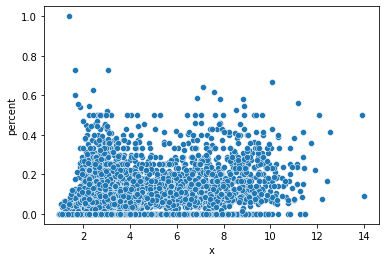

In [8]:
plot_anomaly(mat, r_lof, s_lof, 'rule', 'percent')

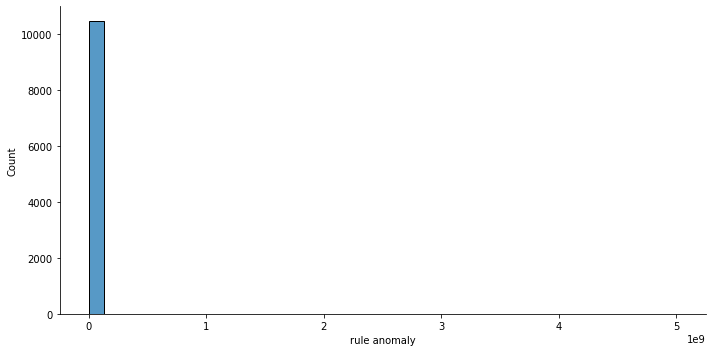

In [21]:
df = pd.DataFrame({ 'rule anomaly': r_lof })
sns.displot(df, x='rule anomaly', bins=40, aspect=2)


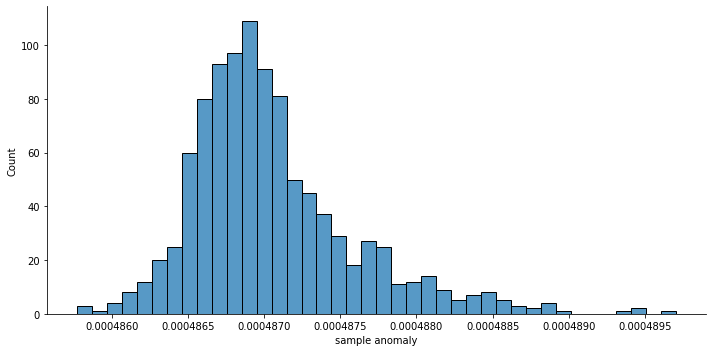

In [14]:
df = pd.DataFrame({ 'sample anomaly': s_lof })
sns.displot(df, x='sample anomaly', bins=40, aspect=2)


In [15]:
global_s_dist = pairwise_distances(X = mat.transpose(), metric='jaccard')
global_r_dist = pairwise_distances(X = mat, metric='jaccard')

Data was converted to boolean for metric jaccard


KeyboardInterrupt: 

In [144]:
clf = LocalOutlierFactor(n_neighbors = 5, metric="precomputed")
clf.fit(global_r_dist)
r_lof = -clf.negative_outlier_factor_

9757 1.2242020788031809
8002 1.2440432271331625
2222 0.9562305417212833
7841 0.9880298966816021


In [134]:
(r_lof > r_lof.mean() + r_lof.std() * 3).sum()

87

In [7]:
def mutual_anomaly_detection(mat, row_conf = None, col_conf = None, lambda_ = 0.85):
    if row_conf is None:
        row_conf = np.ones(mat.shape[0])
    if col_conf is None:
        col_conf = np.ones(mat.shape[1])

    S = mat.shape[1]
    R = mat.shape[0]
    M = np.identity(R + S)
    M[R:, :R] = mat.transpose()
    M[:R, R:] = mat
    A = np.ones(S + R) / (S + R)

    s_dist = global_s_dist
    clf = LocalOutlierFactor(metric="precomputed")
    clf.fit(s_dist)
    col_lof = -clf.negative_outlier_factor_

    r_dist = global_r_dist
    clf = LocalOutlierFactor(metric="precomputed")
    clf.fit(r_dist)
    row_lof = -clf.negative_outlier_factor_

    for i in range(1):
        row_weight = row_lof / np.sum(row_lof)
        col_weight = col_lof / np.sum(col_lof)
        P = np.concatenate((row_weight, col_weight), axis = 0)
        MA = M * A
        MA2 = np.matmul(M, A)
        P = P / P.sum()
        MA2 = MA2 / MA2.sum()
        A = lambda_ * MA2 + (1 - lambda_) * P
        s_dist = pairwise_distances(X = MA[R:, :R], metric='euclidean') 
        clf = LocalOutlierFactor(metric="precomputed")
        clf.fit(s_dist)
        col_lof = -clf.negative_outlier_factor_

        print('iter', i, 'column lof', np.mean(col_lof), np.max(col_lof))
        r_dist = pairwise_distances(X = MA[:R, R:], metric='euclidean')
        clf = LocalOutlierFactor(metric="precomputed")
        clf.fit(r_dist)
        row_lof = -clf.negative_outlier_factor_

    return A[:R], A[R:]

In [8]:

mat = np.array([np.array(r['sample']) for r in rules])
mat = mat.astype(np.float32)

r_lof, s_lof = mutual_anomaly_detection(mat, row_conf=r_conf, col_conf=s_conf)
for i in [9757, 8002, 2222, 7841]:
    print(i, r_lof[i])

iter 0 column lof 1.004269507284359 1.0362324180448024
9757 0.00012752325977374905
8002 5.651100085285729e-05
2222 0.00038076672719588906
7841 0.00031819059235184817


In [124]:
p3 = [i for i, p in enumerate(rules) if p['level'] > 1]
print(len(r_lof[p3]))
c = r_lof[p3].argsort()[::-1][:80]
c = [p3[i] for i in c]
print(c)

80
[7023, 2222, 7841, 1216, 10056, 9483, 945, 133, 1034, 5251, 2910, 1217, 2749, 1775, 8850, 9360, 9974, 5793, 7178, 7172, 9287, 2203, 5598, 5837, 5235, 4791, 5137, 10168, 211, 616, 2463, 9540, 7247, 218, 5904, 9757, 8782, 9746, 7068, 802, 1, 10267, 3332, 9113, 8065, 5638, 752, 425, 8896, 10277, 4458, 4686, 9794, 9089, 1077, 1173, 348, 7845, 7698, 9608, 4517, 8719, 637, 3149, 4968, 8002, 1182, 5731, 1748, 4127, 7305, 6286, 6420, 8901, 5165, 8070, 9424, 8625, 2803, 3428]


In [51]:
print(r_lof[:100])

[2.26426298e-05 1.67535163e-04 8.42317184e-05 3.26400900e-05
 6.22947193e-05 4.00685161e-05 3.94055754e-05 3.30057959e-05
 2.22689338e-05 1.81319041e-05 2.80109615e-05 1.69716537e-05
 8.31202694e-06 3.60342991e-05 1.07585679e-05 4.07143100e-05
 7.34120345e-05 9.65834218e-05 7.72043063e-05 7.26262797e-05
 3.12400973e-05 6.46301301e-05 4.15449755e-05 1.03745194e-04
 5.65239363e-05 1.01451517e-04 5.09008196e-05 2.98892986e-05
 2.10519116e-04 3.51539081e-05 4.48120813e-05 3.90656460e-05
 1.21074045e-04 8.69154465e-05 1.45199244e-04 1.06201538e-04
 4.99073539e-05 5.09188282e-05 6.53466607e-05 5.91420007e-05
 7.31636392e-05 4.31710124e-05 1.00238506e-04 1.52070723e-04
 4.18690471e-05 1.70628726e-05 1.06841852e-04 3.61877255e-05
 7.60748117e-05 6.39063356e-05 2.95758725e-05 5.40908049e-05
 1.70058428e-05 4.64283953e-05 5.49669305e-05 2.94747112e-05
 3.08655982e-05 4.96829761e-05 2.11927960e-05 4.30226941e-05
 4.07899140e-05 1.70395822e-05 1.49468999e-05 5.78007583e-05
 6.25300141e-05 4.627774

<AxesSubplot:xlabel='x', ylabel='y'>

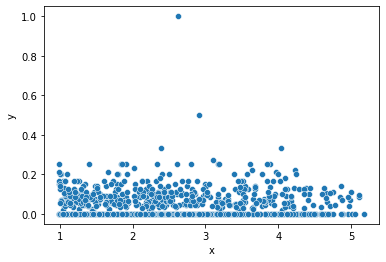

In [76]:
ordered_r_lof = sorted(r_lof)[::-1][len(r_lof) // 20]
px = []
py = []
for i in range(len(s_lof)):
    x = s_lof[i]
    idxes = np.flatnonzero(mat[i, :])
    #y = np.median(r_lof[idxes])
    #y = np.max(r_lof[idxes])
    y = np.sum(r_lof[idxes] > ordered_r_lof) / len(idxes)
    px.append(x)
    py.append(y)
df = pd.DataFrame({ 'x': px, 'y': py })
sns.scatterplot(data=df, x='x', y='y')
